IoU for the road class: 0.22685660515671854


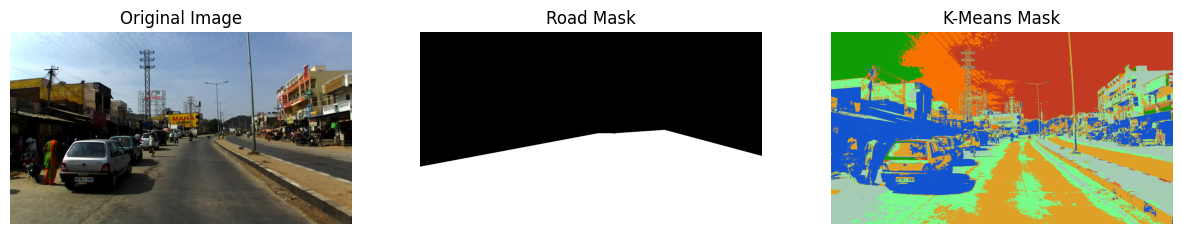

In [12]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def process_image_and_json(image_path, json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    road_polygon = None
    for obj in data['objects']:
        if obj['label'] == 'road':
            road_polygon = np.array(obj['polygon'], dtype=np.int32)
            break

    if road_polygon is None:
        return None, None, None, None

    road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    cv2.fillPoly(road_mask, [road_polygon], 255)

    img = cv2.imread(image_path)
    img_flat = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=7, random_state=0).fit(img_flat)
    segmented_img = kmeans.labels_.reshape(img.shape[:2])

    # Create a color image for the K-Means mask
    kmeans_mask_color = np.zeros_like(img)
    for i in range(34):
        kmeans_mask_color[segmented_img == i] = np.random.randint(0, 255, 3)

    # Assuming the road class is the largest segment
    road_segment = 1 if np.sum(segmented_img == 1) > np.sum(segmented_img == 0) else 0
    kmeans_mask = (segmented_img == road_segment).astype(np.uint8) * 255

    iou = calculate_iou(road_mask, kmeans_mask)
    return img, road_mask, kmeans_mask_color, iou

# Paths to the image and JSON file
image_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg'
json_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\train\201\frame0029_gtFine_polygons.json'

img, road_mask, kmeans_mask_color, iou = process_image_and_json(image_path, json_path)
if iou is not None:
    print(f"IoU for the road class: {iou}")

    # Display the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(road_mask, cmap='gray')
    axs[1].set_title('Road Mask')
    axs[1].axis('off')

    axs[2].imshow(kmeans_mask_color)
    axs[2].set_title('K-Means Mask')
    axs[2].axis('off')

    plt.show()
else:
    print("Road class not found in the JSON file.")

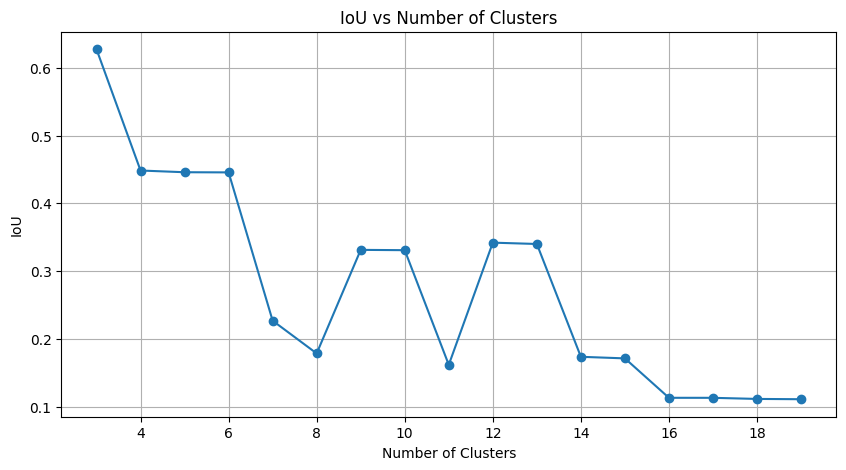

IoU for the road class with 19 clusters: 0.11099587899564195


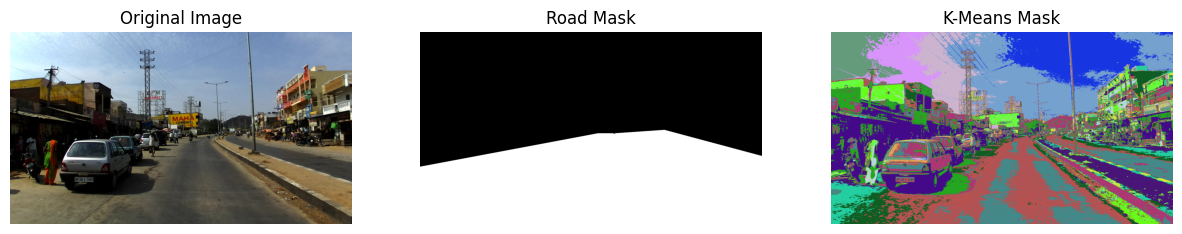

In [16]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def process_image_and_json(image_path, json_path, n_clusters):
    with open(json_path, 'r') as file:
        data = json.load(file)

    road_polygon = None
    for obj in data['objects']:
        if obj['label'] == 'road':
            road_polygon = np.array(obj['polygon'], dtype=np.int32)
            break

    if road_polygon is None:
        return None, None, None, None

    road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    cv2.fillPoly(road_mask, [road_polygon], 255)

    img = cv2.imread(image_path)
    img_flat = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(img_flat)
    segmented_img = kmeans.labels_.reshape(img.shape[:2])

    # Calculate the centroid of the road polygon
    centroid = np.mean(road_polygon, axis=0).astype(int)

    # Find the cluster that contains the centroid
    road_segment = segmented_img[centroid[1], centroid[0]]
    kmeans_mask = (segmented_img == road_segment).astype(np.uint8) * 255

    # Create a color image for the K-Means mask
    kmeans_mask_color = np.zeros_like(img)
    for i in range(n_clusters):
        kmeans_mask_color[segmented_img == i] = np.random.randint(0, 255, 3)

    iou = calculate_iou(road_mask, kmeans_mask)
    return img, road_mask, kmeans_mask_color, iou

# Paths to the image and JSON file
image_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg'
json_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\train\201\frame0029_gtFine_polygons.json'

ious = []
clusters = range(3, 20)
for n_clusters in clusters:
    img, road_mask, kmeans_mask_color, iou = process_image_and_json(image_path, json_path, n_clusters)
    if iou is not None:
        ious.append(iou)
    else:
        ious.append(0)  # Append 0 if road class is not found

# Plot IoU against number of clusters
plt.figure(figsize=(10, 5))
plt.plot(clusters, ious, marker='o')
plt.title('IoU vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('IoU')
plt.grid(True)
plt.show()

# Display the images for the last number of clusters
if iou is not None:
    print(f"IoU for the road class with {n_clusters} clusters: {iou}")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(road_mask, cmap='gray')
    axs[1].set_title('Road Mask')
    axs[1].axis('off')

    axs[2].imshow(kmeans_mask_color)
    axs[2].set_title('K-Means Mask')
    axs[2].axis('off')

    plt.show()
else:
    print("Road class not found in the JSON file.")

In [17]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def process_image_and_json(image_path, json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    road_polygon = None
    for obj in data['objects']:
        if obj['label'] == 'road':
            road_polygon = np.array(obj['polygon'], dtype=np.int32)
            break

    if road_polygon is None:
        return None

    road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    cv2.fillPoly(road_mask, [road_polygon], 255)

    img = cv2.imread(image_path)
    img_flat = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=10, random_state=0).fit(img_flat)
    segmented_img = kmeans.labels_.reshape(img.shape[:2])

    # Assuming the road class is the largest segment
    road_segment = 1 if np.sum(segmented_img == 1) > np.sum(segmented_img == 0) else 0
    kmeans_mask = (segmented_img == road_segment).astype(np.uint8) * 255

    iou = calculate_iou(road_mask, kmeans_mask)
    return iou

def process_directory(image_dir, json_dir):
    ious = []
    for root, _, files in tqdm(os.walk(image_dir)):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                json_path = os.path.join(json_dir, os.path.relpath(root, image_dir), file.replace('_leftImg8bit.jpg', '_gtFine_polygons.json'))
                if os.path.exists(json_path):
                    iou = process_image_and_json(image_path, json_path)
                    if iou is not None:
                        ious.append(iou)
    return ious

val_image_dir = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\val'
val_json_dir = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\val'

val_ious = process_directory(val_image_dir, val_json_dir)

all_ious = val_ious
mean_iou = np.mean(all_ious)
print(f"Mean IoU for the road class: {mean_iou}")

9it [02:51, 19.10s/it]


KeyboardInterrupt: 